In [116]:
import pandas as pd
from transformers import T5TokenizerFast, T5ForConditionalGeneration
from datasets import Dataset, load_from_disk

### Load Model and Tokenizer

In [117]:

MODEL_CKPT = 'paust/pko-t5-larget'
MODEL_CKPT = 'paust/pko-t5-base'

tokenizer = T5TokenizerFast.from_pretrained(MODEL_CKPT)
# model = T5ForConditionalGeneration.from_pretrained(MODEL_CKPT)

print(MODEL_CKPT)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


paust/pko-t5-base


### Load Data

In [118]:
DATA_PATH = 'data/model_dev_raw/model_dev_raw_v3.pickle'

In [119]:
df_data = pd.read_pickle(DATA_PATH)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14930 entries, 0 to 14999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             14930 non-null  int64         
 1   create_date    14930 non-null  datetime64[ns]
 2   title          14930 non-null  object        
 3   title_content  14930 non-null  object        
 4   len_tokenized  14930 non-null  int64         
 5   label          14930 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 816.5+ KB


In [120]:
# for idx, row in df_data.iterrows():
#     if idx == 1000:
#         break
#     print(f'Row {idx}')
#     print('input')
#     print(row.title_content)
#     print()
#     print('output')
#     print(row.label)
#     print()
#     print()

### 전처리 계획

- 라벨 앞뒤로 붙은 punctuation 제거
- 라벨 내 key-phrases 중에서 띄어쓰기 기준으로 길이 4 이상인 항목 제거 (보류)

### Preprocess

In [121]:
def remove_ending_seps(string):
    string = string.strip()
    if string[0] in ';.':
        string = string[1:]
    if string[-1] in ';.':
        string = string[:-1]
    return string.strip()

test_case = '; 농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융; '
test_case = ';농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융. '

remove_ending_seps(test_case)

'농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융'

In [122]:
def remove_quotes(string):
    quotes = '"' + "'"
    key_phrases = [key_phrase.strip() for key_phrase in string.split(';')]

    temp = []
    for key_phrase in key_phrases:
        if key_phrase[0] in quotes and key_phrase[-1] in quotes:
            key_phrase = key_phrase[1:-1]
        temp.append(key_phrase)
    
    return '; '.join(temp)

test_case = "'농협은행'; 'ESG경영'; '상생경영'; '제1회 대한민국 리딩금융 ESG 어워드'; '친환경경영'; '지배구조'; '녹색금융'"

remove_quotes(test_case)

'농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융'

In [123]:
def preprocess(df):
    df.rename(columns={'title_content': 'input_text', 'label': 'target_text'}, inplace=True)

    df['target_text'] = df['target_text'].apply(remove_ending_seps)
    df['target_text'] = df['target_text'].apply(remove_quotes)
    
    return df

In [124]:
preprocessed_data = preprocess(df_data)

In [125]:
preprocessed_data['len_tokenized_target_text'] = preprocessed_data.target_text.apply(lambda x: len(tokenizer(x)['input_ids']))

(<Axes: >,
 count    14930.000000
 mean        55.724715
 std         21.056362
 min         29.000000
 25%         44.000000
 50%         51.000000
 75%         61.000000
 max        397.000000
 Name: len_tokenized_target_text, dtype: float64)

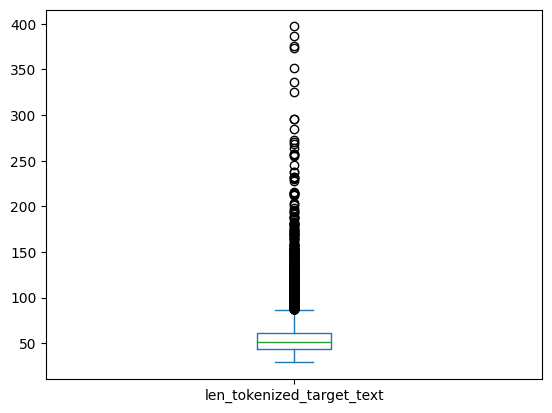

In [126]:
preprocessed_data.len_tokenized_target_text.plot(kind='box'), preprocessed_data.len_tokenized_target_text.describe()

### seq len under 64 lables only

In [127]:
checker = preprocessed_data.len_tokenized_target_text < 64
preprocessed_data = preprocessed_data[checker]
preprocessed_data.len_tokenized_target_text.describe()

count    11683.000000
mean        48.047334
std          7.867650
min         29.000000
25%         42.000000
50%         48.000000
75%         54.000000
max         63.000000
Name: len_tokenized_target_text, dtype: float64

In [ ]:
# for idx, row in preprocessed_data.iterrows():
#     # if idx == 10:
#     #     break
#     print(f'Row {idx}')
#     print('target_text')
#     print(row.target_text)
#     print()

### Save Preprocessed Data

In [129]:
preprocessed_data.to_pickle('data/model_dev/model_dev_v3.pickle')

### Encoding / Train Eval Split

In [ ]:
prefix = "generate keyphrases: "

max_input_length = 1024
max_target_length = 64

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["input_text"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding="max_length")

    labels = tokenizer(examples["target_text"], max_length=max_target_length, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
dataset = Dataset.from_pandas(preprocessed_data).shuffle(seed=100).train_test_split(0.2, seed=100)
train_dataset = dataset['train']
eval_dataset = dataset['test']

In [ ]:
train_dataset = train_dataset.map(preprocess_function, 
                                  batched=True, 
                                  num_proc=NCPU, 
                                  remove_columns=train_dataset.column_names)

eval_dataset = eval_dataset.map(preprocess_function, 
                                batched=True, 
                                num_proc=NCPU, 
                                remove_columns=eval_dataset.column_names)
print(train_dataset)
print(eval_dataset)

In [ ]:
train_dataset.save_to_disk('data/model_dev/model_dev_v3_train.hf')
eval_dataset.save_to_disk('data/model_dev/model_dev_v3_eval.hf')

In [ ]:
train_dataset = load_from_disk('data/model_dev/model_dev_v3_train.hf')
eval_dataset = load_from_disk('data/model_dev/model_dev_v3_eval.hf')